In [323]:
import numpy as np
import torch
import torch
from egnn_pytorch import EGNN_Network

import torch.nn as nn
import numpy as np
import random
import torch.nn.functional as F
import itertools

import torch
from matplotlib import pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import dgl
from dgl.nn import GraphConv
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

charges = {'HIS': 1, 'LYS': 1,
           'ASP': -1, 'GLU': -1,  # carboxylate
           'CYS': 0, 'CYS': 0,
           'TYR': 0}   # thiol and phenol prot
prot = charges.keys()

Rs, solvents = {}, {}
counter = 0

with open("/home/jrhoernschemeyer/Desktop/thesis/PDB/102l-red.pdb", "r") as f:
    resis = {}
    xs = []
    for line in f:
        L = line.split()

        if line.startswith("ATOM"):
            resname, atomname = L[3], L[2]
            if resname in prot:
                resname = resname + str(L[5])

                if resname in resis:
                    resis[resname][f"{atomname} {counter}"] = (float(L[6]), float(L[7]), float(L[8]))
                    counter += 1
                else:
                    resis[resname] = {f"{atomname} {counter}": (float(L[6]), float(L[7]), float(L[8]))}
                    counter += 1

            else:  # resname in noprot
                resname, atomname, resnum = L[3], L[2], L[5]
                xs.append((float(L[6]), float(L[7]), float(L[8])))
                counter += 1

        elif line.startswith("HETATM"):
            resname = L[3] + str(L[5])
            atomname = L[2]
            if resname in solvents:
                solvents[resname][f"{atomname} {str(counter)}"] = (float(L[6]), float(L[7]), float(L[8]))
                counter += 1
            else:
                solvents[resname] = {f"{atomname} {str(counter)}": (float(L[6]), float(L[7]), float(L[8]))}
            counter += 1

all_ppos, all_pspecies = {}, {}
positions = []
resi_keys=tuple(resis.keys())

pspecies={}
for res in resi_keys:
    pspecies, Rs = {},{}
    residict = resis[res]
    for atom, pos in residict.items():
        node = atom.split()  # name, pos
        #rint(node)
        nodei = int(node[1])
        pspecies.update({node[0] : nodei})
        #rint(nodei)
        #print(i)
        #i += 1
        #rint({node[0] : nodei}, pos)
        Rs[nodei] = pos


    all_ppos[res] = Rs  # ({res: {node[1]: pos}})
    all_pspecies[res] = pspecies


cations = {'HIS': ("HD1", "HD2", "HE1", "HE2"),
        'ASP':None,
        "LYS":("HZ1", "HZ2","HZ3"),
        "TYR":"HH",
        "GLU":None,
        "CYS":'HG',
        "ARG": ("HE11","HE12", "HE21", "HE22"),
        "THR":"HG1",
        "SER":"HG",
        "TRP":"HE1"}


anions = {"HIS":("ND1", "ND2"),
          "ASP":("OD1","OD2"),
          "LYS":"NZ",
          "TYR":"OH",
          "GLU":("OE1", "OE2"),
          "CYS":"SG",
          "ARG": ("NE1","NE2"),
          "THR":"OG1",
          "SER":"OG",
          "TRP":"NE1"}

labels = {"HIS":6.08,
          "ASP":3.9,
          "LYS":10.5,
          "TYR":10.1,
          "GLU":4.3,
          "CYS":8.28}


s={}
all_ions={}
for key in resi_keys:
    
    resname = key[:3]
    species = all_pspecies[key]
    ion = torch.zeros(len(species))


    counter1, counter2 =0, 0
    species_map={}
    for k, v in species.items():
        
        element = k[0]
        #print(element)
        if element not in species_map:
            species_map[element] = counter1
            counter1 +=1
        species[k] = counter2
        counter2 += 1
 
    cats =cations[resname]
    if cats:
        cs = [c for c in cats if c is not None]
        cats =[species.get(a) for a in cs]
        cs = [c for c in cats if c is not None]
        ion[cs] = 1


    ans = [species.get(a) for a in anions[resname]]
    ion[ans]  =-1
    
    all_ions[key] = ion

    feats = np.where(np.array(list(species.keys())) == species_map['H'], torch.tensor(1), torch.tensor(0))
    #feats = torch.tensor(feats).unsqueeze(0)


#turn species into numbers
#get pos tensor

els = list(species.keys())
es = [a[0] for a in els]

final=[]
#f#eats = np.where(np.array(es) == species_map['H'], torch.tensor(1), torch.tensor(0))
#feats
fs = [a for a in es if a == "H"]
for a in es:
    if a=="H":
        final.append(1)
    else:
        final.append(0)

Hs = torch.tensor(final)




/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [324]:

from torch.nn import LazyLinear



def boltzmax(x, temp):
    """
    Computes Boltzmann probabilities (Euclidean Softmax) for a tensor of distances.
    
    Parameters:
        distances (torch.Tensor): feature tensor
        temperature (float): The temperature parameter to control the sharpness.
    
    Returns:
        torch.Tensor: A tensor of notprobabilities 
    """
    # Scale the distances by temperature
    scaled_distances = x / temp
    
    # Exponentiate the scaled distances
    x = torch.exp(scaled_distances)
    p = x / torch.max(x) #doing max instead of 
    
    return p


def contrastive_loss(latent_features, species):
    """seperates latent space by enforcing dissimilarity between negative and positive ions"""

    loss = 0.0

    positive_pairs = [(i, j) for i, j in itertools.combinations(range(len(species)), 2) if species[i] == species[j]]
    negative_pairs = [(i, j) for i, j in itertools.combinations(range(3), 2) if species[i] != species[j]]


    # Positive pairs
    for i, j in positive_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2)  # Euclidean distance
        loss += dist ** 2  # Minimize distance for positive pairs

    # Negative pairs
    for i, j in negative_pairs:
        z_i, z_j = latent_features[i], latent_features[j]
        dist = torch.norm(z_i - z_j, p=2) #seperation
        loss += torch.clamp(dist, min=0) ** 2 #enforce sepertion



    return loss / (len(positive_pairs) + len(negative_pairs))



def model(num_nodes, dim, depth, lr, weight_decay):
    net = EGNN_Network(
        num_tokens = 100, #vocabulary siye, number of unique species
        num_positions = num_nodes,  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = dim,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
        depth = depth, #number of layers #deeper need more memort to store intermediate reps
        num_nearest_neighbors = 1, #number of nearest neighbors to consider #make this the max hood size
        coor_weights_clamp_value = 2   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    return net, optimizer



def loop(nepochs, coors, species, ion_labels, model, optimizer, negative_slope):

    es = [a[0] for a in species]
    final=[]
    for a in es:
        if a=="H":
            final.append(1)
        else:
            final.append(0)
    Hs = torch.tensor(final)

    for epoch in range(200):

        optimizer.zero_grad()
        x, _ = model(Hs.unsqueeze(0), coors.unsqueeze(0)) #can turn off return po
        rep = boltzmax((nn.LeakyReLU(negative_slope=negative_slope)(x)), 15)[0] #apply activation (output raw numbers), and softmax (output nonnormalized probabilities)  
        L = contrastive_loss(rep, ion_labels)
        L.backward()
        optimizer.step()

    print(L)    
    return rep


def plot(x, D):

    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(D[:, 0], D[:, 1], D[:, 2], label="Updated")

    # Add labels to points
    for i in range(len(D)):
        ax.text(D[i, 0], D[i, 1], D[i, 2], species[i], fontsize=9)

    plt.legend()
    plt.title("3D Position Transformation")
    plt.show()

    import pandas as pd 

    r = [[float(v), s] for v,s in zip(out, species)]

    df = pd.DataFrame(r, columns=["Value", "Label"])

    # Calculate the mean of the column
    mean_value = df["Value"].mean()

    # Calculate separation from the mean
    df["Separation"] = abs(df["Value"]) - abs(mean_value)

    # Plot separation
    plt.figure(figsize=(10, 6))
    plt.bar(df["Label"], df["Separation"], color='blue', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("Atom Label")
    plt.ylabel("Separation from Mean")
    plt.title("Visualization of Separation for Each Atom")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return [(np.sum(d), s) for d, s in zip(D,species)]

maxes, Ns, scs=[],[],[]

#for i in range(1):
for sample in all_ppos.keys():
    if sample[:3] != "ARG":
        coords = torch.tensor(list(all_ppos[sample].values()))
        species = (list(all_pspecies[sample]))
        net, optimizer = model(len(species), 3, 2, .01, .01) # dim, depth, lr, weight decay


        x = loop(10, coords, species, all_ions[sample], net, optimizer, 1) #margin, negative slope
        out = torch.mean(x, dim=1)
        f = out.unsqueeze(0).detach().numpy()*coords.detach().numpy().T
        combined = np.column_stack(f).flatten()
        
        D=np.gradient(np.gradient(combined)).reshape(-1,3)
        #plot(x[0], D)
        print(sample)
        #plt.show()
        
        def loop2(D, sample):

            r = sample[:3]
            #out = torch.mean(x, dim=1)
            pnet = EGNN_Network(
            num_tokens = 6, #vocabulary siye, number of unique species
            num_positions = len(D),  #number of nodes         # unless what you are passing in is an unordered set, set this to the maximum sequence length
            dim = 1,# #internal rep size. c has square dependence. richer rep but overfitting for small d.s.
            depth = 2, #number of layers #deeper need more memort to store intermediate reps
            num_nearest_neighbors = 2, #number of nearest neighbors to consider #make this the max hood size
            dropout=.03,
            m_pool_method='mean')


            loss = torch.nn.HuberLoss()
            
            optimizer3 = torch.optim.Adam(pnet.parameters(), lr=.1, weight_decay=.1)
            

            ins = torch.ones(len(D))
            ins[0]=0
            ins[-1] = 2#,10,10

            

            for epoch in range(200):
                optimizer3.zero_grad()
                y=pnet(torch.tensor(ins, dtype=int).unsqueeze(0), torch.tensor(D).unsqueeze(0))[0]
                label=labels[r]
                loss2=loss(max(y[0][1::]), torch.tensor(label))
                loss2.backward()
                optimizer3.step()

            a=y[0].detach().numpy()
            maxes.append((np.where(a == max(a[1::]))[0], max(a[1::])))
            Ns.append(a[0])
            scs.append(a[-1])


            return maxes, Ns, scs
        m, n, scs = loop2(D, sample)
        
        











tensor(0.0010, grad_fn=<DivBackward0>)
GLU5


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


tensor(0.0007, grad_fn=<DivBackward0>)
ASP10
tensor(0.0005, grad_fn=<DivBackward0>)
GLU11
tensor(0.0004, grad_fn=<DivBackward0>)
LYS16


KeyboardInterrupt: 

In [69]:
scindex=[]
for id in resis.keys():
    scindex.append(len(resis[id]))

N = [np.array((0, v.item())) for v in n]
S = [np.array((i, v.item())) for i,v in zip(scindex, scs)]

     
B = [np.concatenate((i[0], i[1])) for i in m] #maxes, is in the backbone
#len(resis["GLU5"])

#np.vstack([N,S,B]).reshape(-1,2)

triangles=[]
for i in range(len(N)):
    triangles.append(np.array([N[i], S[i], B[i]]))
    

In [ ]:
resis
for k, v in all_pspecies.items():
    resi, val = k[0], k[3:]
    #ens[k[0]]  len(v)
    print(resi,val)

G 5
A 10
G 11
L 16
T 18
L 19
A 20
G 22
T 24
T 25
H 31
L 35
L 44
G 46
A 48
L 49
L 61
A 62
G 63
G 65
L 66
A 71
A 73
L 84
L 86
T 89
A 90
A 93
G 109
L 125
A 128
G 129
L 136
T 140
L 148
A 160
T 162
L 163


In [293]:
resiss = {'H': 1, 'L': 2,
           'A': -1, 'G': -2,  # carboxylate
           'C': 0, 'T': 3} 


num2seq = dict([(b,a) for a,b in resiss.items()])
seq2pk = dict([(a[0],b) for a,b in labels.items()])
def create_protein_graph(sequence, coordinates, distance_threshold=None):
    """
    Creates a DGL graph for a protein.

    Parameters:
    - sequence (list): List of residues (single-letter codes).
    - coordinates (np.array or torch.Tensor): Shape (N, 3), 3D coordinates of residues.
    - distance_threshold (float): Distance to consider creating an edge.

    Returns:
    - DGLGraph
    """
    num_residues = len(resis) #48
    g = dgl.graph(([], []), num_nodes=3)


    # Add edges based on sequential adjacency
    src = list(range(num_residues - 1))
    dst = list(range(1, num_residues))
    g.add_edges(src, dst)
    g.add_edges(dst, src)  # Make it bidirectional

    # Optionally add edges based on spatial proximity
    if coordinates is not None:

        # Ensure coordinates are NumPy arrays
        if isinstance(coordinates, torch.Tensor):
            coordinates = coordinates.numpy()
        
        for i in range(num_residues):
            for j in range(i + 1, num_residues):
                dist = np.linalg.norm(coordinates[i] - coordinates[j])
                #print(i, j, coordinates)
                #print("dist",dist)
                #print(j, i+1)
                if dist <= 10 and j != i + 1:
                    print("hi", dist)
                    
                    g.add_edges([i], [j])
                    g.add_edges([j], [i])

    return g



sequence = []
graphs = []
features = []
#targets = []  # Ensure you have a corresponding target for each sample
all_coords=[]
sequences=[]

for sample in all_ppos.keys():
    # Extract coordinates for the current sample

    
    # Process residue information
    r = sample[:4]
    if r != "ARG":
        r = resiss[r[0]] 
        sequence_sample = [r] * 3 # Adjust based on your actual data structure
        sequences.append(sequence_sample)
        sequence.append(sequence_sample[0])

        
        
for seq, coords in zip(sequences, triangles):
        # Create the graph for the current sample
        g = create_protein_graph(seq, tpos, distance_threshold=100)
        g = dgl.add_self_loop(g)
        graphs.append(g)

        # Encode features
        features.append(np.array(seq))
        #print(sequence_sample)

        # Append target (replace with your actual target extraction logic)
        #targets.append(seq2pk[num2seq[seq[0]]])



        all_coords.append(coords)

features = torch.tensor([np.concatenate([feats]) for feats in features])





#targets=[seq2pk[num2seq[s]] for s in sequence]
len(targets)
targets=[3.49973,
1.13269,
4.32236,
10.366,
11.1131,
11.2963,
2.78064,
2.79104,
10.3907,
9.83911,
7.78241,
10.9913,
9.36903,
3.27824,
2.62777,
11.4944,
10.5661,
3.60359,
2.22548,
4.09207,
10.8503,
1.76499,
3.03049,
10.377,
11.2809,
10.1192,
2.5044,
0.977022,
3.33801,
10.0178,
3.46841,
3.48914,
10.2195,
9.58874,
11.1147,
2.95551,
14.4481,
10.9523]


hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.240429236392968
hi 9.579262654296521
hi 8.031452110297364
hi 8.835581135386624
hi 8.24042923

In [294]:
poslist=[]
tpos=[]
for a in all_ppos.keys():
    poslist.append(list(all_ppos[a].values()))

idxs=[]  
for p,b in zip(poslist, triangles):
    idxs.append([y[0] for y in b])
for i, j in zip(idxs, poslist):

    idxs = ([int(k) for k in i])
    m=idxs[-1]
    tpos.append(np.array([j[0], j[-1], j[m]]))
print(torch.tensor(tpos))


tensor([[[ 4.2313e+01,  3.0390e+00,  1.2797e+01],
         [ 4.5773e+01, -9.7400e-01,  1.3473e+01],
         [ 4.4253e+01,  1.9870e+00,  1.1668e+01]],

        [[ 4.3716e+01,  9.8930e+00,  8.6300e+00],
         [ 4.0668e+01,  9.0300e+00,  6.0970e+00],
         [ 4.0668e+01,  9.0300e+00,  6.0970e+00]],

        [[ 4.2896e+01,  1.2141e+01,  1.0143e+01],
         [ 3.8594e+01,  1.3734e+01,  1.0303e+01],
         [ 4.1933e+01,  1.1932e+01,  1.2498e+01]],

        [[ 4.7147e+01,  1.9961e+01,  2.1338e+01],
         [ 4.6300e+01,  2.6739e+01,  2.3517e+01],
         [ 4.8169e+01,  2.4162e+01,  2.3149e+01]],

        [[ 4.3687e+01,  2.3335e+01,  1.8033e+01],
         [ 4.3127e+01,  1.7227e+01,  1.4395e+01],
         [ 4.3246e+01,  2.0114e+01,  1.3916e+01]],

        [[ 4.3244e+01,  2.4712e+01,  1.4715e+01],
         [ 4.1457e+01,  3.2130e+01,  1.3866e+01],
         [ 4.1540e+01,  3.1177e+01,  1.3457e+01]],

        [[ 4.0908e+01,  2.3490e+01,  1.2396e+01],
         [ 3.7355e+01,  2.1394e+01,  1

In [ ]:
poslist

[[(42.313, 3.039, 12.797),
  (42.289, 2.192, 13.364),
  (43.586, 3.293, 12.11),
  (44.298, 3.7, 12.828),
  (43.359, 4.133, 10.909),
  (44.141, 4.992, 10.62),
  (44.253, 1.987, 11.668),
  (43.763, 1.526, 10.811),
  (45.249, 2.264, 11.322),
  (44.624, 1.03, 12.827),
  (43.987, 0.669, 13.635),
  (45.497, 1.397, 13.366),
  (45.297, -0.3, 12.431),
  (45.5, -0.641, 11.262),
  (45.773, -0.974, 13.473)],
 [(43.716, 9.893, 8.63),
  (43.126, 9.067, 8.729),
  (43.019, 11.005, 8.031),
  (43.716, 11.282, 7.24),
  (42.991, 12.293, 8.849),
  (43.058, 13.386, 8.327),
  (41.618, 10.612, 7.575),
  (40.919, 10.104, 8.239),
  (41.287, 11.606, 7.273),
  (41.678, 9.831, 6.281),
  (42.584, 9.953, 5.475),
  (40.668, 9.03, 6.097)],
 [(42.896, 12.141, 10.143),
  (43.416, 11.334, 10.487),
  (42.781, 13.282, 11.034),
  (42.669, 14.189, 10.441),
  (44.046, 13.712, 11.758),
  (44.106, 14.857, 12.188),
  (41.739, 12.927, 12.097),
  (41.769, 13.726, 12.838),
  (41.933, 11.932, 12.498),
  (40.404, 12.639, 11.422),
  (

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1, Training Loss: 65.3281, Validation Loss: 46.9370
Epoch 2, Training Loss: 33.9326, Validation Loss: 23.2757
Epoch 3, Training Loss: 10.1526, Validation Loss: 13.3010
Epoch 4, Training Loss: 8.1472, Validation Loss: 12.5936
Epoch 5, Training Loss: 7.5588, Validation Loss: 13.1531
Epoch 6, Training Loss: 7.4082, Validation Loss: 13.0638
Epoch 7, Training Loss: 7.2022, Validation Loss: 12.8880
Epoch 8, Training Loss: 7.2928, Validation Loss: 12.9255
Epoch 9, Training Loss: 7.7382, Validation Loss: 12.9208
Epoch 10, Training Loss: 7.1400, Validation Loss: 12.6059
Epoch 11, Training Loss: 7.2326, Validation Loss: 12.9390
Epoch 12, Training Loss: 7.2711, Validation Loss: 12.8149
Epoch 13, Training Loss: 6.8634, Validation Loss: 12.4650
Epoch 14, Training Loss: 7.1259, Validation Loss: 12.7548
Epoch 15, Training Loss: 6.8924, Validation Loss: 12.4334
Epoch 16, Training Loss: 7.2660, Validation Loss: 12.3903
Epoch 17, Training Loss: 7.1228, Validation Loss: 12.9199
Epoch 18, Training L

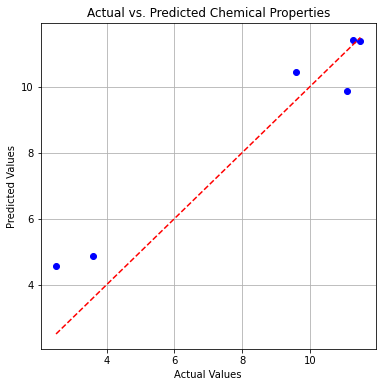

In [ ]:
# Dataset Class
class ProteinDataset(Dataset):
    def __init__(self, graphs, features, targets):
        self.graphs = graphs
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.features[idx], self.targets[idx]

# Model Definition
class ProteinGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(ProteinGCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        #self.conv2 = GraphConv(hidden_feats, hidden_feats)
        self.fc = nn.Linear(hidden_feats, out_feats)

    def forward(self, g, features):
        #print(g,features)
        h = F.relu(self.conv1(g, features))
        #h = F.relu(self.conv2(g, h))
        #print(h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        out = self.fc(hg)
        return out

# Evaluation Function
def evaluate_and_plot(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_g, batch_f, batch_t in test_loader:
            outputs = model(batch_g, batch_f)
            predictions.extend(outputs)
            actuals.extend(batch_t)
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Plotting
    plt.figure(figsize=(6,6))
    plt.scatter(actuals, predictions, color='blue')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Chemical Properties")
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Diagonal line
    plt.grid(True)
    plt.show()

# Main Execution
if __name__ == "__main__":
    #seqs, coords
    targets = targets  # Replace with actual target values

    # Ensure that the lengths match
    for seq, coord in zip(features, all_coords):
        #print(len(seq), coord.shape)
        assert len(seq) == coord.shape[0], "Sequence length and coordinates length do not match."

    # Create graphs and features
    #graphs = [create_protein_graph(seq, coord) for seq, coord in zip(sequences, coordinates_list)]
    #features = features.unsqueeze(2)#features #torch.tensor(sequences)
    features = torch.tensor(triangles, dtype=torch.float32)

    # Split the data
    train_g, temp_g, train_f, temp_f, train_t, temp_t = train_test_split(
        graphs, features, targets, test_size=0.3, random_state=42)

    val_g, test_g, val_f, test_f, val_t, test_t = train_test_split(
        temp_g, temp_f, temp_t, test_size=0.5, random_state=42)


    from torch.utils.data import DataLoader
    from dgl import batch

    # Define a proper collate function
    def collate_fn(samples):
        graphs, features, targets = zip(*samples)
        batched_graph = batch(graphs)
        batched_features = torch.cat(features, dim=0)
        batched_targets = torch.tensor(targets, dtype=torch.float32)
        # Test batching

        return batched_graph, batched_features, batched_targets

# Define Datasets with the split features
    train_dataset = ProteinDataset(train_g, train_f, train_t)
    val_dataset = ProteinDataset(val_g, val_f, val_t)
    test_dataset = ProteinDataset(test_g, test_f, test_t)
    


    train_loader = DataLoader(
        train_dataset, 
        batch_size=1, 
        shuffle=True, 
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=1, 
        shuffle=False, 
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset, 
        batch_size=1, 
        shuffle=False, 
        collate_fn=collate_fn
    )
    
    # Initialize the model
    in_features = 2 # One-hot encoding
    hidden_features = 2
    out_features = 1  # Regression target

    model = ProteinGCN(in_feats=in_features, hidden_feats=hidden_features, out_feats=out_features)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training Loop
    def train_model(model, train_loader, val_loader, epochs=100):
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch_g, batch_f, batch_t in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_g, batch_f)
                loss = criterion(outputs.squeeze(), torch.tensor(batch_t, dtype=torch.float32))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_g, batch_f, batch_t in val_loader:
                    outputs = model(batch_g, batch_f)
                    loss = criterion(outputs.squeeze(), torch.tensor(batch_t, dtype=torch.float32))
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            
            print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Train the model
    train_model(model, train_loader, val_loader, epochs=100)

    # Evaluate the model
    evaluate_and_plot(model, test_loader)

    # Visualize one of the graphs
    #visualize_graph(test_g)

In [163]:
graphs

[Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3, num_edges=9,
       ndata_schemes={}
       edata_schemes={}),
 Gra

In [343]:
def create_residue_graph(sequence, coordinates, distance_threshold=None):
    """
    Creates a DGL graph for a single residue with 3 nodes.

    Parameters:
    - sequence (list): List of residues (single-letter codes). Should correspond to 3 nodes.
    - coordinates (np.array or torch.Tensor): Shape (3, 3), 3D coordinates of nodes.
    - distance_threshold (float): Distance to consider creating an edge.

    Returns:
    - DGLGraph
    """
    num_nodes = 3  # Each graph has 3 nodes
    g = dgl.graph(([], []), num_nodes=num_nodes)

    # Add edges based on sequential adjacency
    src = [0, 1, 2]
    dst = [1, 2, 0]
    g.add_edges(src, dst)
    g.add_edges(dst, src)  # Make it bidirectional

    # Optionally add edges based on spatial proximity
    if distance_threshold is not None and coordinates is not None:
        if isinstance(coordinates, torch.Tensor):
            coordinates = coordinates.numpy()
        
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                dist = np.linalg.norm(coordinates[i] - coordinates[j])
                if dist <= distance_threshold:
                    g.add_edges([i], [j])
                    g.add_edges([j], [i])

    return g

graphs = []
features = []
all_coords = []

for residue_index in range(38):  # Assuming 48 residues
    # Example: Get coordinates for 3 nodes of the current residue
    coords = tpos[residue_index]  # Replace with your actual data source
    #print(coords.shape)
    residue = sequence[residue_index]  # Residue identifier (single-letter code)
    #print(residue)
    # Create a graph for this residue
    g = create_residue_graph([residue] * 3, coords, distance_threshold=5.0)
    print(g)
    #g = dgl.add_self_loop(g)  # Add self-loops
    
    graphs.append(g)

    # Use coordinates as features for the 3 nodes
    #node_features = torch.tensor(coords, dtype=torch.float32)  # Shape: (3, 3)
    features.append(torch.tensor(triangles[residue_index],dtype=torch.float32))
    #print(len(features[0]))
    # Save coordinates for debugging
    all_coords.append(coords)


def create_protein_graph(residue_graphs, residue_positions, distance_threshold):
    """
    Creates a protein-level graph with residue-level information.

    Parameters:
    - residue_graphs (list): List of 48 residue-level graphs (DGLGraphs).
    - residue_positions (torch.Tensor): Shape (48, 3), 3D positions for each residue.
    - distance_threshold (float): Distance threshold for creating edges.

    Returns:
    - protein_graph (DGLGraph): Protein-level graph with 48 nodes.
    """
    num_residues = len(residue_graphs)
    g = dgl.graph(([], []), num_nodes=num_residues)

    # Add edges based on pairwise distances
    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            dist = torch.norm(residue_positions[i] - residue_positions[j])
            if dist <= distance_threshold:
                g.add_edges(i, j)
                g.add_edges(j, i)  # Make it bidirectional

    return g

features_list = [f[-1][1] for f in features]
#features_list
residue_positions = [p[-1] for p in tpos]
#residue_positions

# Create the protein-level graph
protein_graph = create_protein_graph(graphs, torch.tensor(residue_positions), distance_threshold=20.0)

# Add features to the protein-level graph
protein_features = [features.flatten() for features in features_list]  # Flatten (3, 2) -> (6,)
protein_features = torch.stack(protein_features)  # Shape: (48, 6)
protein_graph.ndata['features'] = protein_features


Graph(num_nodes=3, num_edges=10,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=12,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=12,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=10,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=8,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=8,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=12,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=12,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=8,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=8,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=10,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=8,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3, num_edges=8,
      ndata_s

In [297]:


# Dataset Class
class ProteinDataset(Dataset):
    def __init__(self, graphs, features):
        self.graphs = graphs
        self.features = features

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.features[idx]

# Collate Function
def collate_fn(samples):
    graphs, features = zip(*samples)
    batched_graph = dgl.batch(graphs)
    batched_features = torch.cat(features, dim=0)  # Combine features from all graphs
    return batched_graph, batched_features

# Create Dataset and DataLoader
dataset = ProteinDataset(graphs, features)
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

class MultiresolutionGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(MultiresolutionGCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, hidden_feats)
        self.fc = nn.Linear(hidden_feats, out_feats)

    def forward(self, g, features):
        h = F.relu(self.conv1(g, features))  # Node-level features
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')  # Graph-level representation
        return hg


# Model Initialization
in_features = 2  # Each node has 3D coordinates as input
hidden_features = 1
out_features = 1  # Final output for each graph (e.g., regression target)

model = MultiresolutionGCN(in_features, hidden_features, out_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training Loop
for epoch in range(50):
    for batched_graph, batched_features in loader:
        optimizer.zero_grad()
        outputs = model(batched_graph, batched_features)
        # Combine outputs (if needed, e.g., sum or average across graphs)
        loss = criterion(outputs, torch.tensor(targets))  # Adjust targets appropriately
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

#evaluate_and_plot(model, test_loader)
# Example: Aggregating outputs from all graphs
#final_representation = torch.mean(all_graph_outputs, dim=0)  # Shape: (out_features,)



/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 55.2335
Epoch 2, Loss: 34.4170
Epoch 3, Loss: 24.9959
Epoch 4, Loss: 17.0674
Epoch 5, Loss: 23.2493
Epoch 6, Loss: 16.4410
Epoch 7, Loss: 18.0268
Epoch 8, Loss: 20.1867
Epoch 9, Loss: 24.2876
Epoch 10, Loss: 18.1257
Epoch 11, Loss: 22.0838
Epoch 12, Loss: 16.3222
Epoch 13, Loss: 17.4480
Epoch 14, Loss: 16.9352
Epoch 15, Loss: 17.0494
Epoch 16, Loss: 17.8598
Epoch 17, Loss: 16.3339
Epoch 18, Loss: 18.0531
Epoch 19, Loss: 17.4136
Epoch 20, Loss: 17.4218
Epoch 21, Loss: 19.0507
Epoch 22, Loss: 16.8898
Epoch 23, Loss: 16.0733
Epoch 24, Loss: 17.0320
Epoch 25, Loss: 17.0222
Epoch 26, Loss: 17.4297
Epoch 27, Loss: 16.3168
Epoch 28, Loss: 16.8134
Epoch 29, Loss: 16.1028
Epoch 30, Loss: 16.1449
Epoch 31, Loss: 16.8765
Epoch 32, Loss: 17.7003
Epoch 33, Loss: 18.4420
Epoch 34, Loss: 16.1305
Epoch 35, Loss: 16.1465
Epoch 36, Loss: 17.0232
Epoch 37, Loss: 16.5334
Epoch 38, Loss: 16.0293
Epoch 39, Loss: 17.0777
Epoch 40, Loss: 16.2053
Epoch 41, Loss: 16.9618
Epoch 42, Loss: 16.5177
E

In [344]:
protein_graph

Graph(num_nodes=38, num_edges=568,
      ndata_schemes={'features': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})

In [394]:
class MultiresolutionModel(nn.Module):
    def __init__(self, residue_in_feats, residue_hidden_feats, protein_hidden_feats, out_feats):
        super(MultiresolutionModel, self).__init__()
        # Residue-level GCN
        self.residue_gcn1 = GATConv(residue_in_feats, residue_hidden_feats, num_heads=1) #2 
        #self.residue_gcn2 = GATConv(residue_hidden_feats, residue_hidden_feats, num_heads=2) #2

        # Protein-level GCN
        self.protein_gcn1 = GATConv(residue_hidden_feats, protein_hidden_feats, num_heads=1) #2 1
        self.protein_gcn2 = GATConv(protein_hidden_feats, protein_hidden_feats, num_heads=1) 

        # Final output layer
        self.fc = nn.Linear(38,38)

    def forward(self, residue_graphs, residue_features, protein_graph):
        # Step 1: Process residue-level graphs
        residue_embeddings = []
        for g, features in zip(residue_graphs, residue_features):
            h = self.residue_gcn1(g, features)
            #print("h1", h)
            #h = F.relu(self.residue_gcn2(g, h))
            g.ndata['h'] = h
            #print("h",h)
            #residue_embeddings.append(dgl.sum_nodes(g, 'h'))  # Graph-level embedding for the residue
            residue_embeddings.append(features[2][1])
        # Combine residue embeddings into protein graph features
        #print((residue_embeddings))
        residue_embeddings = torch.stack(residue_embeddings)  # Shape: (48, residue_hidden_feats)
        #print((residue_embeddings))
        protein_graph.ndata['features'] = residue_embeddings.unsqueeze(1)
        print(protein_graph.ndata['features'].shape)  # Should print (38, 1)

        # Step 2: Process protein-level graph
        #h = F.relu(self.protein_gcn1(protein_graph, protein_graph.ndata['features']))
        #h = self.protein_gcn2(protein_graph, h)
        #print(h)
        # Output updated residue embeddings
        #protein_graph.ndata['h'] = h
        #updated_residue_embeddings = protein_graph.ndata['h']  # Shape: (48, protein_hidden_feats)
        
        # Optionally, apply a final layer for predictions
        outputs = self.fc(residue_embeddings)  # Shape: (48, out_feats)
        #print(outputs)
        #print("hi",updated_residue_embeddings)
        return outputs

model = MultiresolutionModel(2, 1, 1,38)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=.01)
criterion = nn.HuberLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(graphs, features, protein_graph)  # Shape: (48, out_feats)
    #print(outputs[:3])
    #print(outputs)
    # Compute loss (per residue)
    print(outputs)
    loss = criterion(outputs, torch.tensor(targets))  # Ensure residue_targets is shape (48, out_feats)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


#plt.plot(outputs.detach().numpy())

torch.Size([38, 1])
tensor([-0.1346, -1.7747,  4.2266, -0.6619, -3.6400,  6.0807, -6.4598,  7.9266,
        -3.7451, -2.7069,  5.5894, -2.0335,  8.6579,  1.3428, -4.9933, -7.0343,
        -7.7570,  0.1020,  1.9102, -4.7363, -2.9569,  2.3147, -9.8732,  2.4980,
         6.5751, -1.0645, -4.1979, -2.8650, -0.1606,  5.8571,  0.6542, -0.2793,
         0.1438, -4.2140,  0.9271, -1.2113,  4.7037, -2.4361],
       grad_fn=<AddBackward0>)
Epoch 1, Loss: 7.1748
torch.Size([38, 1])
tensor([ 0.1324, -1.5077,  4.4936, -0.3949, -3.3729,  6.3477, -6.1928,  7.6596,
        -3.4781, -2.4399,  5.8565, -1.7665,  8.9249,  1.6098, -4.7263, -6.7672,
        -7.4899,  0.3691,  2.1772, -4.4693, -2.6899,  2.0476, -9.6062,  2.7650,
         6.8422, -0.7974, -3.9309, -2.5980,  0.1064,  6.1241,  0.9212, -0.0122,
         0.4108, -3.9470,  1.1941, -0.9443,  4.9708, -2.1690],
       grad_fn=<AddBackward0>)
Epoch 2, Loss: 6.9279
torch.Size([38, 1])
tensor([ 0.3994, -1.2407,  4.4065, -0.1278, -3.1059,  6.6147, -5.925

In [ ]:
class MultiresolutionModel(nn.Module):
    def __init__(self, residue_in_feats, residue_hidden_feats, protein_hidden_feats, out_feats):
        super(MultiresolutionModel, self).__init__()
        

        # Final output layer
        self.fc = nn.Linear(38,38,True)

    def forward(self, residue_graphs, residue_features, protein_graph):
        # Step 1: Process residue-level graphs
        residue_embeddings = []
        for g, features in zip(residue_graphs, residue_features):
            residue_embeddings.append(features[2][1])
        residue_embeddings = torch.stack(residue_embeddings)  # Shape: (48, residue_hidden_feats)
        protein_graph.ndata['features'] = residue_embeddings.unsqueeze(1)
        
        outputs = self.fc(residue_embeddings)  # Shape: (48, out_feats)

        return outputs

model = MultiresolutionModel(2, 1, 1,38)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=.005)
criterion = nn.HuberLoss()

X_train, X_temp, y_train, y_temp = train_test_split(all_graphs, torch.tensor(all_targets), test_size=0.3, random_state=42)  # 70% train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test


for epoch in range(100):
    model.train()
    train_loss = 0.0
    

    for graph, label in zip(X_train, y_train):
        optimizer.zero_grad()
        output = model(graphs, features, protein_graph)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for graph, label in zip(X_val, y_val):
                output = model(graphs, features, protein_graph)
                loss = criterion(output, label)
                val_loss += loss.item()

    # Log the losses
        print(f"Epoch [{epoch + 1}/{100}], Train Loss: {train_loss / len(X_train):.4f}, Val Loss: {val_loss / len(X_val):.4f}")


    # Forward pass
    ###outputs = model(graphs, features, protein_graph)  # Shape: (48, out_feats)
    #print(outputs[:3])
    #print(outputs)
    # Compute loss (per residue)
    #print(outputs)
    ###loss = criterion(outputs, torch.tensor(targets))  # Ensure residue_targets is shape (48, out_feats)
    ###loss.backward()
    ###optimizer.step()

    ###print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")



# Testing the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for graph, label in zip(X_test, y_test):
        output = model(graphs=graph['residue_graphs'], features=graph['residue_features'], protein_graph=graph['protein_graph'])
        loss = criterion(output, label)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(X_test):.4f}")

In [631]:
class MultiresolutionModel(nn.Module):
    def __init__(self, residue_in_feats, residue_hidden_feats, protein_hidden_feats, out_feats):
        super(MultiresolutionModel, self).__init__()
        

        # Final output layer
        self.fc = nn.Linear(38,38)

    def forward(self, residue_graphs, residue_features, protein_graph):
        # Step 1: Process residue-level graphs
        residue_embeddings = []
        for g, features in zip(residue_graphs, residue_features):
            residue_embeddings.append(features[2][1])
        residue_embeddings = torch.stack(residue_embeddings)  # Shape: (48, residue_hidden_feats)
        protein_graph.ndata['features'] = residue_embeddings.unsqueeze(1)
        
        outputs = self.fc(residue_embeddings)  # Shape: (48, out_feats)

        return outputs

model = MultiresolutionModel(2, 1, 1,38)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=.1)
criterion = nn.HuberLoss()

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(graphs, features, protein_graph)  # Shape: (48, out_feats)
    #print(outputs[:3])
    #print(outputs)
    # Compute loss (per residue)
    #print(outputs)
    loss = criterion(outputs, torch.tensor(targets))  # Ensure residue_targets is shape (48, out_feats)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


#plt.plot(outputs.detach().numpy())

Epoch 1, Loss: 6.9645
Epoch 2, Loss: 6.7066
Epoch 3, Loss: 6.4562
Epoch 4, Loss: 6.2125
Epoch 5, Loss: 5.9746
Epoch 6, Loss: 5.7408
Epoch 7, Loss: 5.5091
Epoch 8, Loss: 5.2781
Epoch 9, Loss: 5.0476
Epoch 10, Loss: 4.8186
Epoch 11, Loss: 4.5918
Epoch 12, Loss: 4.3689
Epoch 13, Loss: 4.1517
Epoch 14, Loss: 3.9430
Epoch 15, Loss: 3.7448
Epoch 16, Loss: 3.5580
Epoch 17, Loss: 3.3816
Epoch 18, Loss: 3.2154
Epoch 19, Loss: 3.0585
Epoch 20, Loss: 2.9100
Epoch 21, Loss: 2.7687
Epoch 22, Loss: 2.6320
Epoch 23, Loss: 2.4986
Epoch 24, Loss: 2.3689
Epoch 25, Loss: 2.2416
Epoch 26, Loss: 2.1156
Epoch 27, Loss: 1.9919
Epoch 28, Loss: 1.8737
Epoch 29, Loss: 1.7616
Epoch 30, Loss: 1.6548
Epoch 31, Loss: 1.5540
Epoch 32, Loss: 1.4611
Epoch 33, Loss: 1.3775
Epoch 34, Loss: 1.3017
Epoch 35, Loss: 1.2320
Epoch 36, Loss: 1.1676
Epoch 37, Loss: 1.1068
Epoch 38, Loss: 1.0491
Epoch 39, Loss: 0.9934
Epoch 40, Loss: 0.9396
Epoch 41, Loss: 0.8869
Epoch 42, Loss: 0.8346
Epoch 43, Loss: 0.7821
Epoch 44, Loss: 0.72

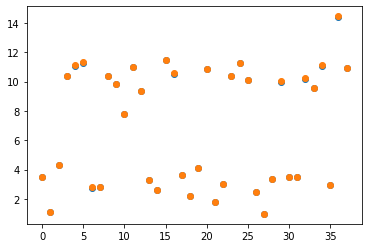

In [632]:
plt.plot(outputs.detach().numpy(), "o")
plt.plot(targets, "o")

In [473]:
model.get_parameter

<bound method Module.get_parameter of MultiresolutionModel(
  (fc): Linear(in_features=38, out_features=38, bias=True)
)>

In [451]:
p

[(47.34, 2.095, 2.404),
 (47.573, 2.603, 1.551),
 (48.558, 1.279, 2.555),
 (48.981, 1.48, 3.539),
 (49.765, 1.809, 1.757),
 (50.824, 2.091, 2.326),
 (48.399, -0.233, 2.395),
 (48.056, -0.305, 1.363),
 (49.175, -0.741, 2.967),
 (47.487, -0.828, 3.442),
 (46.58, -0.232, 3.344),
 (47.864, -0.765, 4.463),
 (47.042, -2.267, 3.144),
 (46.238, -2.213, 3.878),
 (47.175, -3.282, 3.519),
 (47.048, -2.611, 1.653),
 (46.919, -1.937, 0.806),
 (47.961, -3.129, 1.36),
 (45.951, -3.517, 1.236),
 (45.406, -4.179, 1.825),
 (45.199, -2.983, 0.755),
 (46.164, -4.139, 0.43)]

In [453]:
from sklearn.model_selection import train_test_split

# Assuming X is your features and y is your target
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model.fit(X_train, y_train)


AttributeError: 'MultiresolutionModel' object has no attribute 'fit'

In [333]:
sum([-1.8782]+[ 3.2585]+[-2.9181])

-1.5377999999999998

In [331]:
features

[tensor([[ 0.0000,  2.0972],
         [15.0000,  2.0972],
         [ 6.0000,  4.1952]]),
 tensor([[ 0.0000,  1.9036],
         [12.0000,  3.8052],
         [11.0000,  3.8052]]),
 tensor([[ 0.0000,  2.0976],
         [15.0000,  2.0976],
         [ 8.0000,  4.1951]]),
 tensor([[ 0.0000,  3.0834],
         [22.0000,  4.9815],
         [12.0000, 10.2092]]),
 tensor([[ 0.0000,  8.8393],
         [21.0000,  8.8393],
         [16.0000, 10.3562]]),
 tensor([[ 0.0000,  5.1135],
         [22.0000,  5.1751],
         [18.0000, 10.2414]]),
 tensor([[ 0.0000,  1.9898],
         [12.0000,  3.8122],
         [11.0000,  3.8122]]),
 tensor([[ 0.0000,  2.0975],
         [15.0000,  2.0976],
         [13.0000,  4.1951]]),
 tensor([[ 0.0000,  2.6252],
         [21.0000,  2.5737],
         [ 4.0000,  8.7819]]),
 tensor([[ 0.0000,  2.8541],
         [21.0000,  2.8461],
         [ 7.0000,  9.6430]]),
 tensor([[ 0.0000,  2.9657],
         [17.0000,  2.9657],
         [11.0000,  5.9318]]),
 tensor([[ 0.0000,  5

In [309]:
model

MultiresolutionModel(
  (residue_gcn1): GraphConv(in=2, out=20, normalization=both, activation=None)
  (residue_gcn2): GraphConv(in=20, out=20, normalization=both, activation=None)
  (protein_gcn1): GraphConv(in=20, out=20, normalization=both, activation=None)
  (protein_gcn2): GraphConv(in=20, out=20, normalization=both, activation=None)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [308]:
outputs

tensor([[[6.7898]],

        [[8.0364]],

        [[8.4012]],

        [[6.3820]],

        [[7.3390]],

        [[5.7753]],

        [[7.6834]],

        [[6.5896]],

        [[6.5598]],

        [[6.5145]],

        [[7.7674]],

        [[6.3344]],

        [[5.6324]],

        [[6.5095]],

        [[6.2181]],

        [[6.8089]],

        [[5.6935]],

        [[5.2513]],

        [[6.2451]],

        [[7.0816]],

        [[6.4582]],

        [[8.1420]],

        [[7.4990]],

        [[6.7713]],

        [[6.1226]],

        [[7.0818]],

        [[5.7192]],

        [[7.9650]],

        [[7.3803]],

        [[7.4432]],

        [[6.2508]],

        [[5.5136]],

        [[5.4004]],

        [[6.3190]],

        [[6.6143]],

        [[5.8103]],

        [[7.6363]],

        [[5.7134]]], grad_fn=<AddBackward0>)

In [279]:
features

[tensor([[ 0.0000,  2.0972],
         [15.0000,  2.0972],
         [ 6.0000,  4.1952]]),
 tensor([[ 0.0000,  1.9036],
         [12.0000,  3.8052],
         [11.0000,  3.8052]]),
 tensor([[ 0.0000,  2.0976],
         [15.0000,  2.0976],
         [ 8.0000,  4.1951]]),
 tensor([[ 0.0000,  3.0834],
         [22.0000,  4.9815],
         [12.0000, 10.2092]]),
 tensor([[ 0.0000,  8.8393],
         [21.0000,  8.8393],
         [16.0000, 10.3562]]),
 tensor([[ 0.0000,  5.1135],
         [22.0000,  5.1751],
         [18.0000, 10.2414]]),
 tensor([[ 0.0000,  1.9898],
         [12.0000,  3.8122],
         [11.0000,  3.8122]]),
 tensor([[ 0.0000,  2.0975],
         [15.0000,  2.0976],
         [13.0000,  4.1951]]),
 tensor([[ 0.0000,  2.6252],
         [21.0000,  2.5737],
         [ 4.0000,  8.7819]]),
 tensor([[ 0.0000,  2.8541],
         [21.0000,  2.8461],
         [ 7.0000,  9.6430]]),
 tensor([[ 0.0000,  2.9657],
         [17.0000,  2.9657],
         [11.0000,  5.9318]]),
 tensor([[ 0.0000,  5

In [282]:
# Ensure features are a PyTorch tensor and the dimensions match the number of nodes
feats = torch.tensor(features[0], dtype=torch.float32)

# Add the features to your graph
for g in graphs:
    g.ndata['features'] = feats
    


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


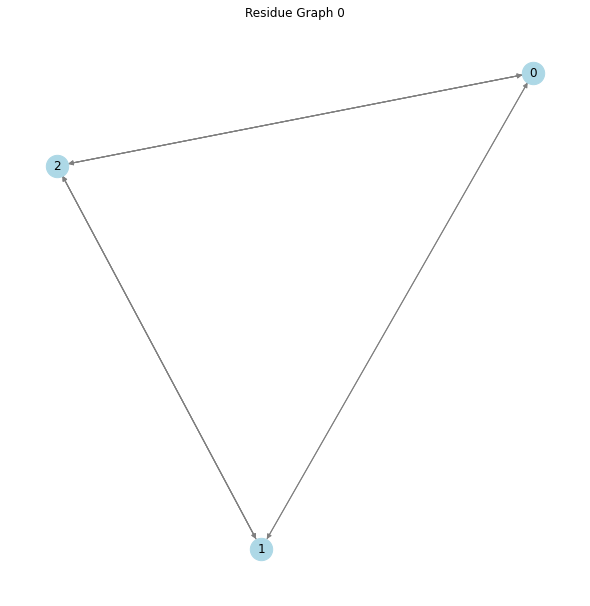

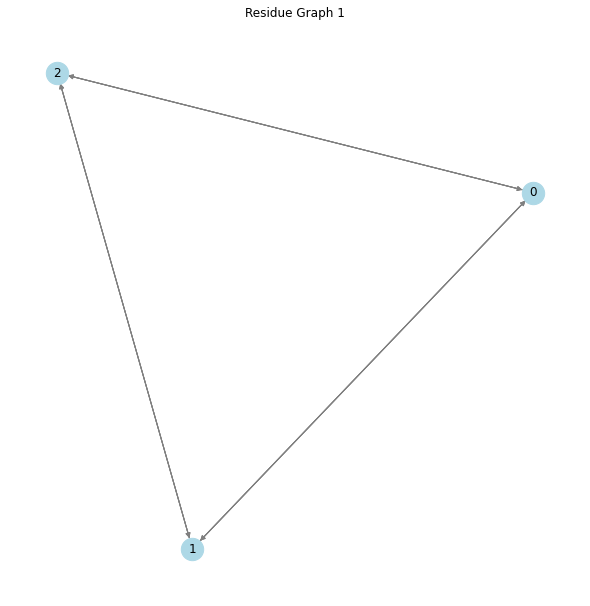

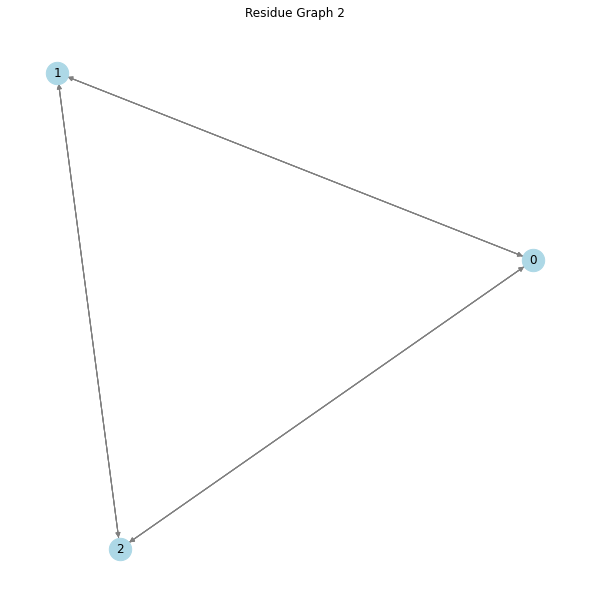

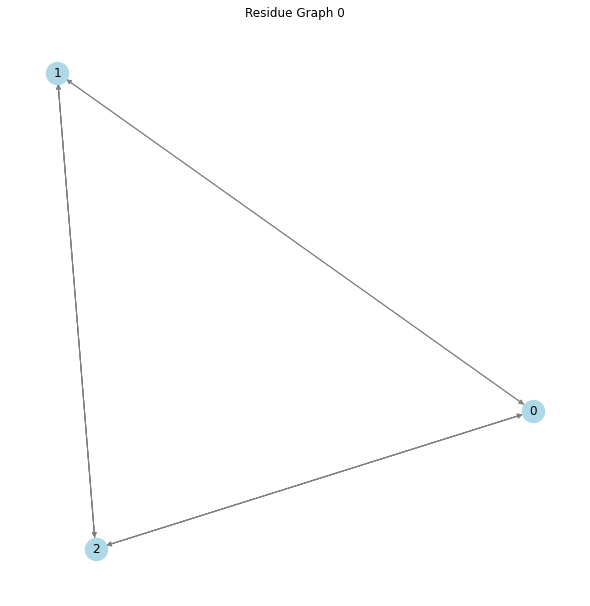

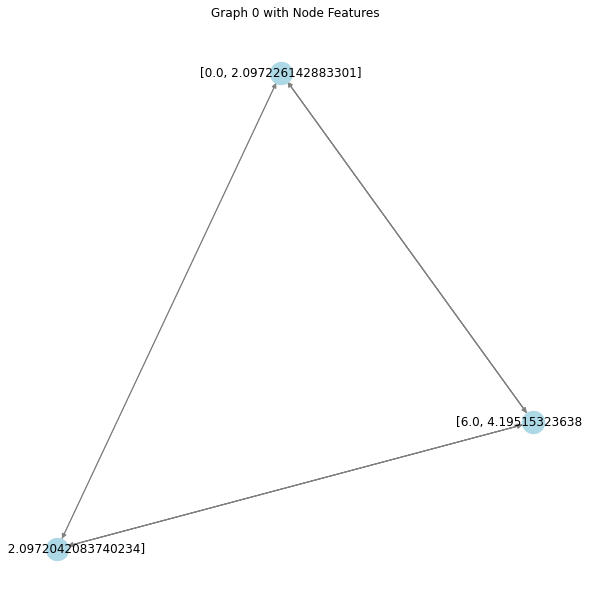

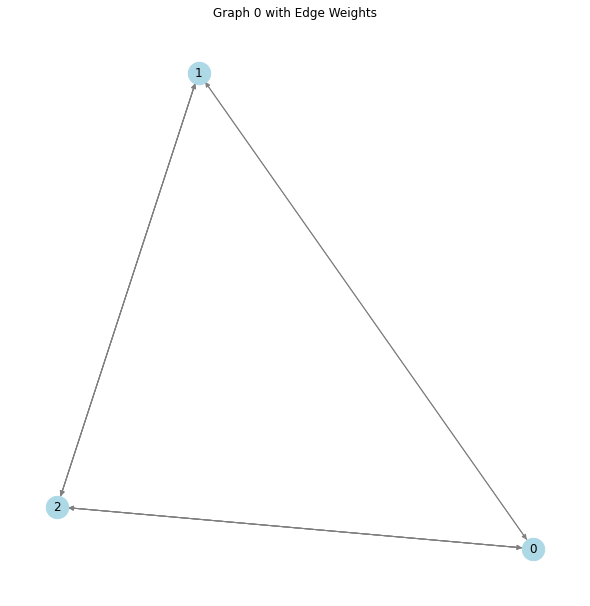

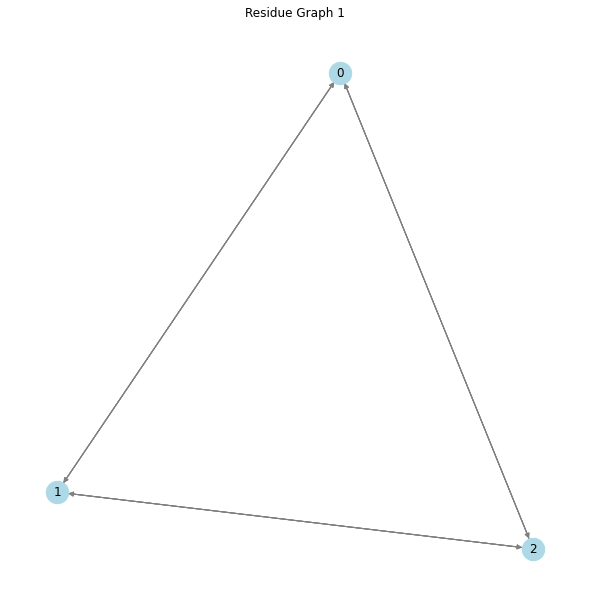

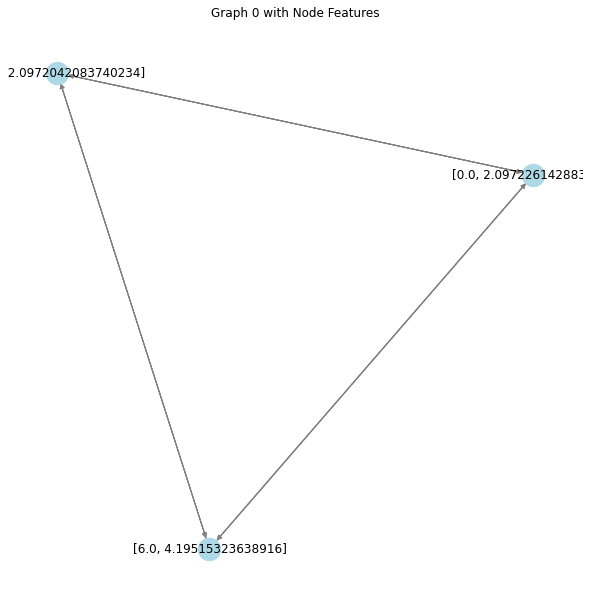

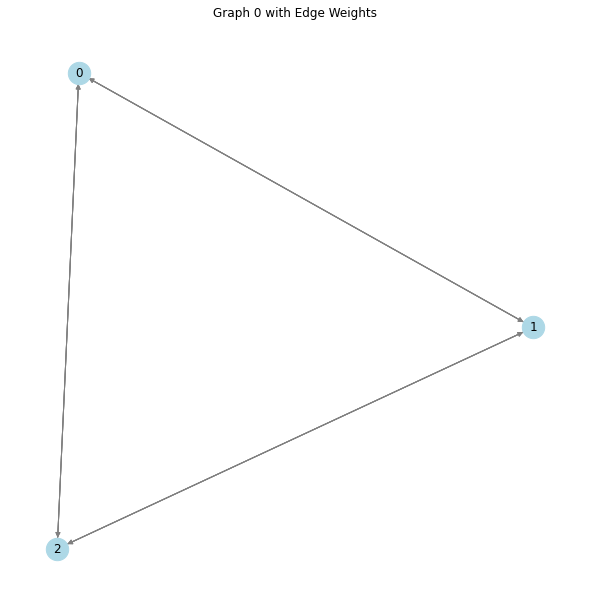

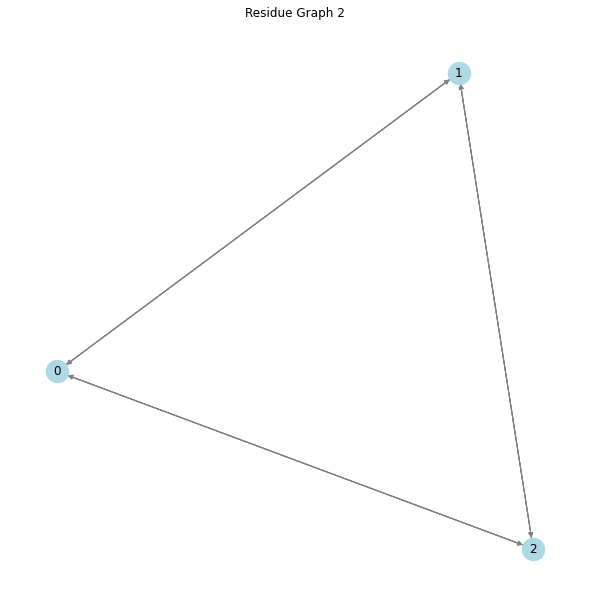

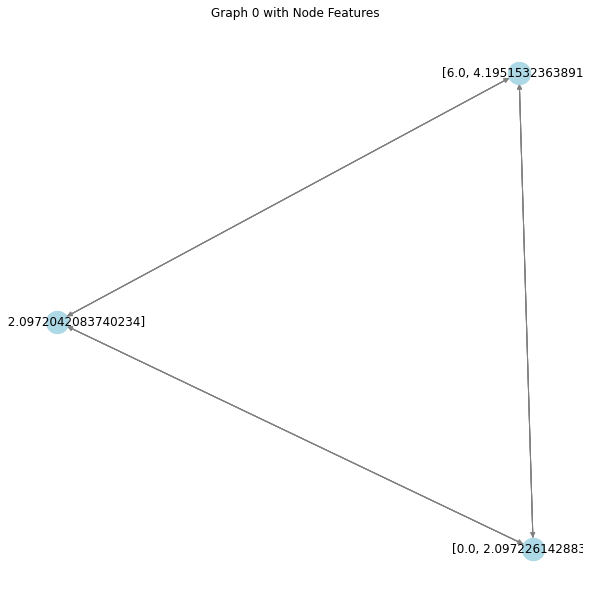

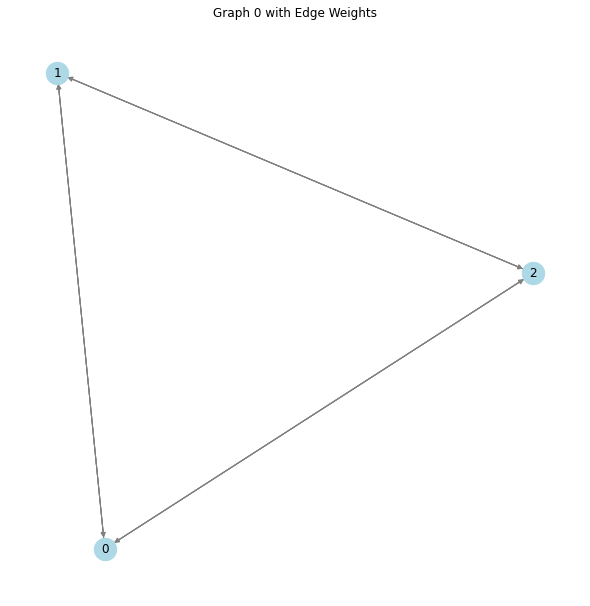

In [284]:
import networkx as nx
import matplotlib.pyplot as plt

# Visualize a single residue graph
def visualize_residue_graph(dgl_graph, title="Residue Graph"):
    nx_graph = dgl_graph.to_networkx()
    pos = nx.spring_layout(nx_graph)  # Layout for better spacing
    
    plt.figure(figsize=(8, 8))
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=500,
        edge_color="gray",
    )
    plt.title(title)
    plt.show()

# Visualize the first few residue graphs
for i, residue_graph in enumerate(graphs[:3]):  # Adjust the range as needed
    visualize_residue_graph(residue_graph, title=f"Residue Graph {i}")

def visualize_graph_with_features(dgl_graph, title="Residue Graph with Features"):
    nx_graph = dgl_graph.to_networkx()
    pos = nx.spring_layout(nx_graph)  # Better layout

    # Extract node features
    node_labels = {
        node: f"{dgl_graph.ndata['features'][node].tolist()}"
        for node in nx_graph.nodes
    }

    plt.figure(figsize=(8, 8))
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        labels=node_labels,
        node_color="lightblue",
        node_size=500,
        edge_color="gray",
    )
    plt.title(title)
    plt.show()

def visualize_graph_with_weights(dgl_graph, title="Graph with Weights"):
    nx_graph = dgl_graph.to_networkx()

    # Example: Add edge weights if available
    if 'weight' in dgl_graph.edata:
        edge_weights = {
            (u, v): f"{dgl_graph.edata['weight'][i].item():.2f}"
            for i, (u, v) in enumerate(nx_graph.edges)
        }
    else:
        edge_weights = None

    pos = nx.spring_layout(nx_graph)
    plt.figure(figsize=(8, 8))

    # Draw the graph
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=500,
        edge_color="gray",
    )
    if edge_weights:
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_weights)

    plt.title(title)
    plt.show()

for i, residue_graph in enumerate(graphs[:3]):  # Adjust the range as needed
    visualize_residue_graph(residue_graph, title=f"Residue Graph {i}")
    visualize_graph_with_features(residue_graph, title="Graph 0 with Node Features")
    visualize_graph_with_weights(residue_graph, title="Graph 0 with Edge Weights")
# Visualize a specific graph with node features
#v#isualize_graph_with_features(graphs[0], title="Graph 0 with Node Features")

# Visualize with weights (if edges have weights)
#visualize_graph_with_weights(graphs[0], title="Graph 0 with Edge Weights")




In [276]:
graphs[20]

Graph(num_nodes=3, num_edges=10,
      ndata_schemes={}
      edata_schemes={})

In [255]:
targets

[3.49973,
 1.13269,
 4.32236,
 10.366,
 11.1131,
 11.2963,
 2.78064,
 2.79104,
 10.3907,
 9.83911,
 7.78241,
 10.9913,
 9.36903,
 3.27824,
 2.62777,
 11.4944,
 10.5661,
 3.60359,
 2.22548,
 4.09207,
 10.8503,
 1.76499,
 3.03049,
 10.377,
 11.2809,
 10.1192,
 2.5044,
 0.977022,
 3.33801,
 10.0178,
 3.46841,
 3.48914,
 10.2195,
 9.58874,
 11.1147,
 2.95551,
 14.4481,
 10.9523]

In [249]:
len(outputs)

38

In [243]:
protein_graph


Graph(num_nodes=38, num_edges=110,
      ndata_schemes={'features': Scheme(shape=(1, 1), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
features

[tensor([[ 0.0000,  2.0972],
         [15.0000,  2.0972],
         [ 6.0000,  4.1952]]),
 tensor([[ 0.0000,  1.9036],
         [12.0000,  3.8052],
         [11.0000,  3.8052]]),
 tensor([[ 0.0000,  2.0976],
         [15.0000,  2.0976],
         [ 8.0000,  4.1951]]),
 tensor([[ 0.0000,  3.0834],
         [22.0000,  4.9815],
         [12.0000, 10.2092]]),
 tensor([[ 0.0000,  8.8393],
         [21.0000,  8.8393],
         [16.0000, 10.3562]]),
 tensor([[ 0.0000,  5.1135],
         [22.0000,  5.1751],
         [18.0000, 10.2414]]),
 tensor([[ 0.0000,  1.9898],
         [12.0000,  3.8122],
         [11.0000,  3.8122]]),
 tensor([[ 0.0000,  2.0975],
         [15.0000,  2.0976],
         [13.0000,  4.1951]]),
 tensor([[ 0.0000,  2.6252],
         [21.0000,  2.5737],
         [ 4.0000,  8.7819]]),
 tensor([[ 0.0000,  2.8541],
         [21.0000,  2.8461],
         [ 7.0000,  9.6430]]),
 tensor([[ 0.0000,  2.9657],
         [17.0000,  2.9657],
         [11.0000,  5.9318]]),
 tensor([[ 0.0000,  5

In [231]:
len(features)

38

In [207]:
print(loader)

8


In [ ]:
for batched_graph, batched_features in loader:
    print(batched_graph)

Graph(num_nodes=24, num_edges=78,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=24, num_edges=80,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=24, num_edges=76,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=24, num_edges=84,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=18, num_edges=62,
      ndata_schemes={}
      edata_schemes={})
